Based on [Credit Card Fraud detection](https://colab.research.google.com/drive/1Jy3IiJenxeEO6TtfctlnZSaoNJo3sIZv?usp=sharing#scrollTo=3HNwy5i02WGN)

In [16]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_curve, 
    classification_report, 
    confusion_matrix
)
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import matplotlib.image as img
import seaborn as sns

import logging
import datetime

datetime.date(2023, 3, 3)

In [31]:
today = datetime.datetime.today().date()
logging.basicConfig(
    filename=f"../log/autoenc_{today}.log",
    filemode='w',
    format='%(name)s - %(levelname)s - %(message)s'
)
logging.info("Autoencoder process started")

AttributeError: 'NoneType' object has no attribute 'info'

## Explore data

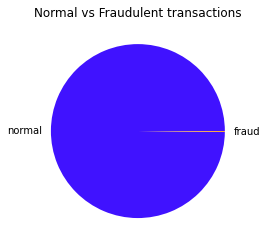

In [2]:
# read data
data = pd.read_csv("../data/creditcard.csv")

# an ugly plot to see distribution of targets
orange, purple = '#ffa022', '#4012ff'
fig, ax = plt.subplots()
ax.pie(
    data.groupby(['Class']).Class.count(),
    labels=['normal', 'fraud'], 
    colors=[purple, orange]
)
plt.title('Normal vs Fraudulent transactions')
plt.show()

In [4]:
# take a random sample of 1000 normal transactions
# and all fraud transactions
non_fraud = data.loc[data['Class']==0].sample(1000)
fraud = data.loc[data['Class']==1]

# shuffle and separate into features and labels
df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis=1).values
y = df['Class'].values

/var/folders/5f/7_2jkfbj58x6cf8373dprpfw0000gn/T/ipykernel_6244/1970605312.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)


In [5]:
def tsne_plot(X, y, name, title='TSNE plot of Fraud and Non Fraud'):
    tsne = TSNE(
        n_components=2,
        random_state=24,
        learning_rate=200
    )
    x_t = tsne.fit_transform(X)

    plt.figure(figsize=(12,8))
    plt.scatter(
        x_t[np.where(y==0), 0],
        x_t[np.where(y==0), 1],
        color='darkorange',
        alpha=0.7,
        label='Non Fraud'
    )
    plt.scatter(
        x_t[np.where(y==1), 0],
        x_t[np.where(y==1), 1],
        color='mediumblue',
        alpha=0.7,
        label='fraud'
    )

    plt.legend(loc='best')
    plt.title(title, fontsize=16)
    plt.savefig(name)
    plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/transformers/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


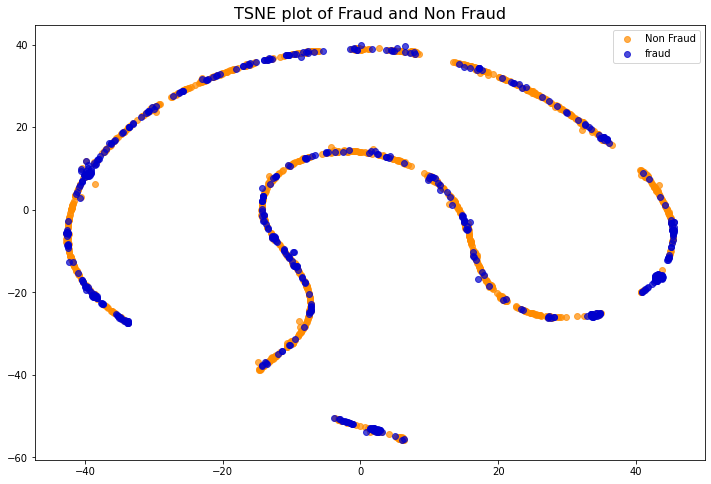

In [6]:
tsne_plot(X, y, name='../images/original.png')

## Train an Autoencoder

In [8]:
# Convert relative 'Time' measure to hour of day
data["Time"] = data["Time"].apply(
    lambda x: x/3600 % 24
)

# Scale 'Time' and 'Amount'
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data["Time"] = StandardScaler().fit_transform(data['Time'].values.reshape(-1,1))

# separate fraudulent transactions from normal transactions
norm_data, fraud_data = data.loc[data['Class']==0], data.loc[data['Class']==1]

# based on source asumptions
# Training data will be 2000 normal samples
# Validation data will be 1000 samples, approximately half fraud and half normal samples; shuffled and with indices reset
# We leave out 200 normal samples and 50 fraud samples for a final test dataset of 250 unseen samples; we'll choose a random subsample of these later
train_data = norm_data.iloc[:2000, :]
val_data = pd.concat(
    [norm_data.iloc[2000:2558,:], fraud_data.iloc[:442, :]],
    axis=0
).sample(frac=1).reset_index(drop=True)
test_samples = pd.concat(
    [norm_data.iloc[2558:2608], fraud_data.iloc[442:,:]],
    axis=0
).sample(frac=1).reset_index(drop=True)

**Asumption to use Autoencoders:**</br>
Autoencoders learn an implicit representation of normality from the abundant “normal” samples, allowing us to reserve our sparse fraudulent data samples for testing

In [22]:
# define hyperparameters
hyper_params = {
    'learning_rate': 1e-1/10,
    'epochs': 150,
    'batch_size': 32,
    'weight_decay': 1e-8,
    'threshold': 0.75
}
logging.info('hyperparameters used: ', hyper_params)

In [10]:
# create dataloaders for training and validation sets
train_target = torch.tensor(
    train_data['Class'].values.astype(np.float32)
)
train = torch.tensor(
    train_data.drop('Class', axis=1).values.astype(np.float32)
)
train_tensor = data_utils.TensorDataset(train, train_target)
train_loader = data_utils.DataLoader(
    dataset=train_tensor,
    batch_size=hyper_params['batch_size'],
    shuffle=True
)

# val
val_target = torch.tensor(
    val_data['Class'].values.astype(np.float32)
)
val = torch.tensor(
    val_data.drop('Class', axis=1).values.astype(np.float32)
)
val_tensor = data_utils.TensorDataset(val, val_target)
val_loader = data_utils.DataLoader(
    dataset=val_tensor,
    batch_size=1,
    shuffle=True
)

In [11]:
class Autoencoder(nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(30, 14),
            nn.Tanh(),
            nn.Linear(14, 7),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(7, 14),
            nn.Tanh(),
            nn.Linear(14, 30),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [28]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyper_params['learning_rate'],
    weight_decay=hyper_params['weight_decay']
)
logging.info('model defined: ', model)
logging.info('criterion defined: ', criterion)
logging.info('optimizer defined: ', optimizer)

In [30]:
for epoch in range(hyper_params['epochs']):
    losses = []
    for (data, _) in train_loader:
        # forward
        output = model(data)
        loss = criterion(output, data)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())

    logging.info('epoch loss', np.mean(losses), epoch = epoch+1)

    losses = []
    labels = []
    preds = []
    embeds = []

    for data, label in val_loader:
        # forward
        reconstructed = model(data)
        loss = torch.sigmoid(criterion(reconstructed, data)).item()
        losses.append(round(loss, 6))
        labels.append(label.item())
        preds.append(reconstructed[0][-1].item())
        embeds.append(reconstructed[0][:-1].detach().cpu().numpy())

    if epoch == (hyper_params['epochs'] - 1):
        print('logging table')
        df = pd.DataFrame()
        df['Reconstructed_Loss'] = losses
        df['Labels_gt'] = labels
        df['Labels_preds'] = [int(x>=hyper_params['threshold']) for x in losses]
print('Complete')

logging table
Complete


## Metrics

In [32]:
# define plot functions
def plot_precision_recall_curves(df):
    precision, recall, thresholds = precision_recall_curve(labels, preds)

    # plot precision recall tradeoff
    sns.set(style="white")
    plt.figure(figsize=(8,6))
    plt.step(recall, precision, color=purple, alpha=0.4, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color=purple)
    plt.title('Recall vs Precision', fontsize=16)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    print(plt.show())

    # plot precision and recall for different thresholds
    plt.figure(figsize=(8,6))
    plt.plot(thresholds, precision[1:], label="Precision", color=orange, linewidth=2.5)
    plt.plot(thresholds, recall[1:], label="Recall", color=purple, alpha=0.9, linewidth=2.5)
    plt.title('Precision and recall for different threshold values', fontsize=16)
    plt.xlabel('Threshold')
    plt.ylabel('Precision/Recall')
    plt.legend()
    plt.show()

In [40]:
def reconstruction_error_plot(df, ylims= (None, None), title='Reconstruction error for different classes'):
    groups = df.groupby('Labels_gt')
    sns.set(style="white")
    sns.set_palette(sns.color_palette([orange, purple]))
    fig, ax = plt.subplots(figsize=(8,6))
    
    for name, group in groups:
        ax.plot(
            group.index,
            group.Reconstructed_Loss,
            marker='o',
            ms=5,
            linestyle='',
            label='Fraud' if name==1 else "Nonfraud"
        )
    
    ax.hlines(
        hyper_params['threshold'],
        ax.get_xlim()[0],
        ax.get_xlim()[1],
        colors='r',
        zorder=100,
        label='Threshold',
        linestyles='--'
    )
    ax.legend()
    plt.title(title, fontsize=16)
    plt.xlabel("Data point index")
    plt.ylabel("Reconstruction error")
    plt.ylim(top=ylims[0], bottom=ylims[1])
    plt.legend(loc='best')
    plt.show()

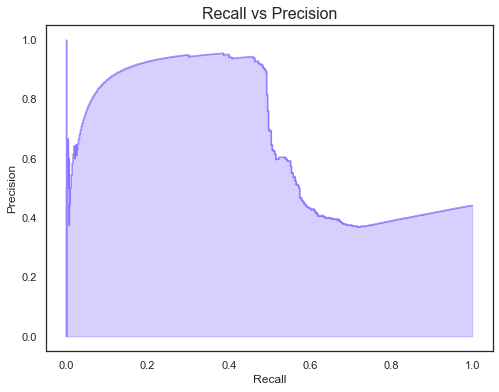

None


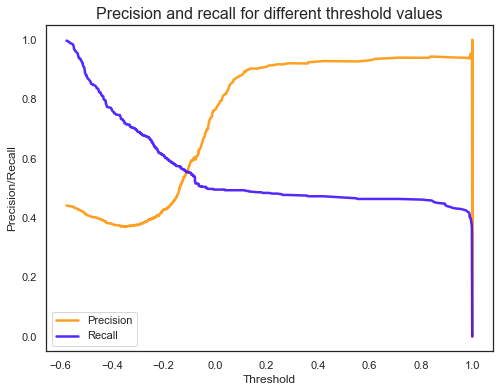

In [34]:
plot_precision_recall_curves(df)

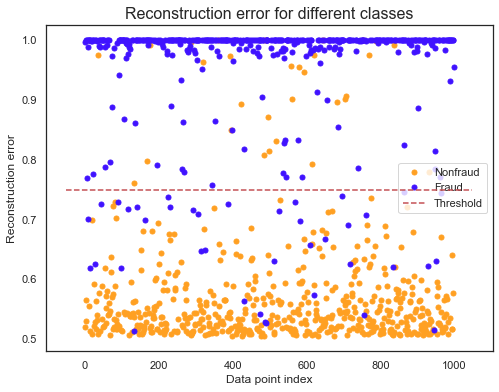

In [41]:
reconstruction_error_plot(df)

/opt/homebrew/Caskroom/miniforge/base/envs/transformers/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


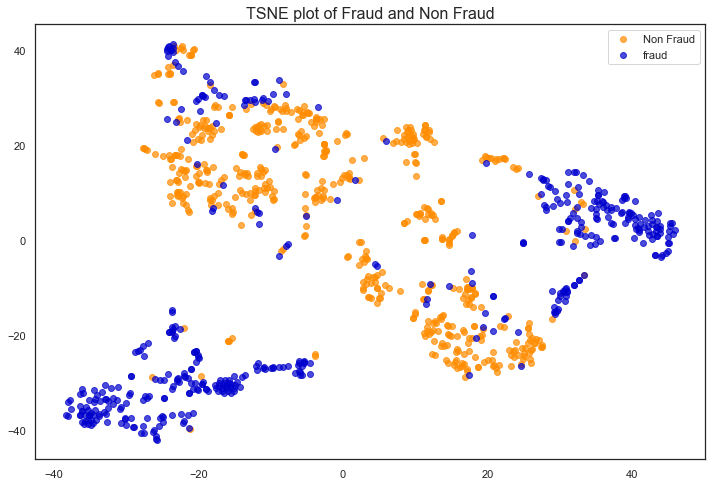

In [43]:
X = np.array(embeds)
y = df['Labels_gt'].values
tsne_plot(X, y, name='../images/latent_rep.png')

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

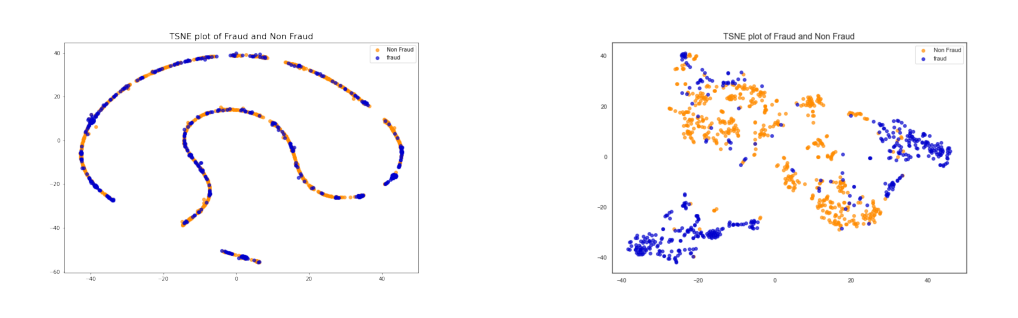

In [45]:
# do the versus of original tsne and embedded tsne
sns.set(style='white')
plt.figure(figsize=(18,12))

plt.subplot(1, 2, 1)
plt.imshow(img.imread("../images/original.png"))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img.imread('../images/latent_rep.png'))
plt.axis('off')

plt.tight_layout

So, embeddeings learned by the Autoencoder are much easier to separate than raw data

In [47]:
print(classification_report(df.Labels_gt, df.Labels_preds))

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       558
         1.0       0.93      0.91      0.92       442

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



## Test on unseen data